In [2]:
# Load in libraries that will be used. 
import os
import json
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.cm

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [3]:
# Read in business data and save Pittsburgh restaurant data into a dataframe
file = "business.json"

with open(file, 'r') as f:
    business = [json.loads(line) for line in f]
    
business_df = pd.DataFrame(business)
restaurant_df = business_df[business_df['categories'].apply(lambda x: 'Restaurants' in x)]
PGH = restaurant_df[restaurant_df['city'] == "Pittsburgh"].copy()
PGH["location"] = PGH["latitude"].map(str) +','+ PGH["longitude"].map(str)

In [4]:
# Read in the neighborhood file from Zillow shape file, which will be used in plotting the neighborhood outline.
neighborhoods = gpd.read_file(os.path.join(r"PA_neighborhood/",
                       "ZillowNeighborhoods-PA.shp"))
Pittsburgh_neighborhood = neighborhoods[neighborhoods['City'] == 'Pittsburgh'].copy()


# Create a neighborhood_updated in the PGH dataframe and fill in neighborhood information based on the Zillow shapefile. 
# this is to check the consistency between Zillow neighborhood and Yelp assigned neighborhood 
PGH['neighborhood_updated'] = ''

for index, row in PGH.iterrows():
    location = Point(float(row['longitude']),float(row['latitude']))
    for index2, row2 in Pittsburgh_neighborhood.iterrows():
        if row2['geometry'].contains(location):     
            PGH.at[index, 'neighborhood_updated'] = row2['Name']


In [5]:
# Now read in review data and save review data into a dataframe
file = "review.json"
with open(file, 'r') as f: 
    review = [json.loads(line) for line in f]
    
review_df = pd.DataFrame(review)

review_df['date'] = pd.to_datetime(review_df['date'])
review_count = review_df.groupby(['business_id',
                           review_df.date]).size().to_frame(name = 'count').reset_index()

In [6]:
# Merge two data frames and select several columns that might be of interest for this project.
df_combo = pd.merge(PGH, review_count, how = 'left', on ='business_id')
PGH_Yelp_Count = df_combo[['name','address', 'business_id', 'latitude','longitude','location','neighborhood_updated','postal_code','review_count','stars','date','count']].copy()

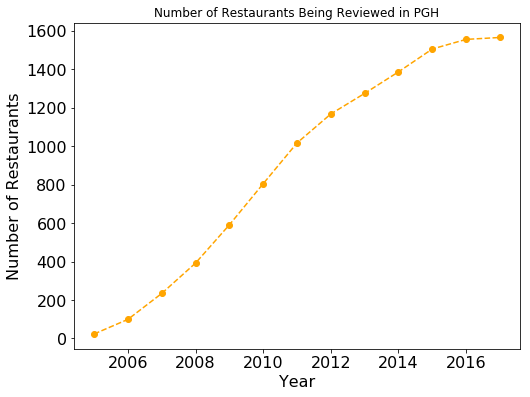

In [7]:
# Plot the number of reviewed restaurants in Pittsburgh each year
%matplotlib inline

PGH_res_year = PGH_Yelp_Count.groupby(PGH_Yelp_Count.date.dt.year)['business_id'].nunique()

fig = plt.figure(figsize=(8, 6))
PGH_res_year.plot(title='Number of Restaurants Being Reviewed in PGH',
                     fontsize=16, marker='o', color='orange', linestyle='dashed')

plt.xlabel('Year',fontsize=16)
plt.ylabel('Number of Restaurants',fontsize=16)
plt.ticklabel_format(useOffset=False)
#plt.savefig('Num_restaurants.png')


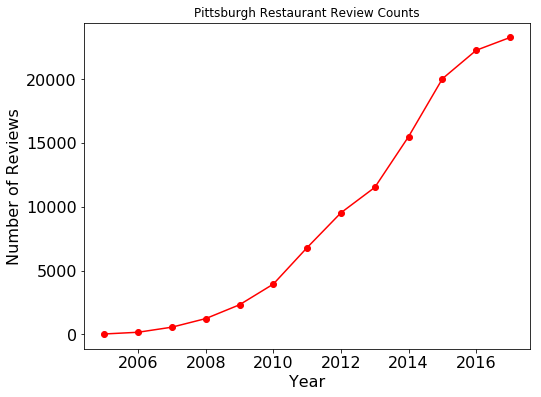

In [8]:
# Plot the number of reviews per year for Pittsburgh
reviews_year = PGH_Yelp_Count.groupby(PGH_Yelp_Count.date.dt.year).size()

fig = plt.figure(figsize=(8, 6))

reviews_year.plot(title='Pittsburgh Restaurant Review Counts',
                     fontsize=16, marker='o', color='red')

plt.xlabel('Year',fontsize=16)
plt.ylabel('Number of Reviews',fontsize=16)
plt.ticklabel_format(useOffset=False)
plt.savefig('PGH_restaurant_sum.png', bbox_inches='tight')

In [9]:
# Summarize monthly review count for each neighborhood in Pittsburgh. 
PGH_review_summary = PGH_Yelp_Count[['neighborhood_updated','postal_code','date','count']].copy()
PGH_review_summary['Year'] = PGH_review_summary['date'].dt.year
PGH_review_summary['Month'] = PGH_review_summary['date'].dt.month
PGH_sum_year_month = PGH_review_summary.groupby(['neighborhood_updated','Year','Month']).sum().reset_index()

# Replace empty neighborhood fields with "Uncategorized Neighborhood"
for index, row in PGH_sum_year_month.iterrows():
    if row['neighborhood_updated'] == '':
        PGH_sum_year_month.at[index, 'neighborhood_updated'] = 'Uncategorized'
        

In [10]:
# pivot and transpose the table for time series analysis
# save the dataframe as a .csv file
PGH_sum_year_month['Date'] = pd.to_datetime(PGH_sum_year_month[['Year','Month']].assign(Day=1))
PGH_pivot = PGH_sum_year_month.pivot(index='neighborhood_updated', columns='Date', values='count')
PGH_pivot.index.name = None
PGH_time_series = PGH_pivot.T
PGH_time_series_NA_cleaned = PGH_time_series.fillna(0)
PGH_time_series_NA_cleaned.index.name = None
PGH_time_series_NA_cleaned.to_csv('Yelp_ReviewCount.csv',sep ='\t',index_label='Month')

In [11]:
# Save the number of restaurants in Pittsburgh being reviewed each year. 
PGH_restaurant_summary = PGH_Yelp_Count[['neighborhood_updated','business_id','date','count']].copy()
PGH_restaurant_summary['Year'] = PGH_restaurant_summary['date'].dt.year
PGH_restaurant_summary['Month'] = PGH_restaurant_summary['date'].dt.month
PGH_restaurant_count = PGH_restaurant_summary.groupby(['neighborhood_updated','Year'])['business_id'].nunique().reset_index()

for index, row in PGH_restaurant_count.iterrows():
    if row['neighborhood_updated'] == '':
        PGH_restaurant_count.at[index, 'neighborhood_updated'] = 'Uncategorized'
        
PGH_res_pivot = PGH_restaurant_count.pivot(index='neighborhood_updated', columns='Year', values='business_id')
PGH_res_pivot.index.name = None
PGH_res_summary = PGH_res_pivot.T
PGH_res_summary.to_csv('Yelp_RestaurantCount.csv',sep ='\t',index_label='Year')
